Lets first read in all the generated graphs. These encompass the training, testing and validation set. 

In [1]:
import pickle 

with open('../../graphs/data/ERC/MELD/val_dialogue_graphs.pkl', 'rb') as f:
    MELD_val_dialogue_graphs = pickle.load(f)

with open('../../graphs/data/ERC/MELD/test_dialogue_graphs.pkl', 'rb') as f:
    MELD_test_dialogue_graphs = pickle.load(f)

with open('../../graphs/data/ERC/MELD/train_dialogue_graphs.pkl', 'rb') as f:
    MELD_train_dialogue_graphs = pickle.load(f)


with open('../../graphs/data/ERC/MELD/augmented_dialogue_graphs.pkl', 'rb') as f:
    MELD_augmented_dialogue_graphs = pickle.load(f)



In [2]:
with open('../../graphs/data/ERC/IEMOCAP/test_dialogue_graphs.pkl', 'rb') as f:
    IEMOCAP_test_dialogue_graphs = pickle.load(f)

with open('../../graphs/data/ERC/IEMOCAP/train_dialogue_graphs.pkl', 'rb') as f:
    IEMOCAP_train_dialogue_graphs = pickle.load(f)

Below we define the testing, training, and validation sets

In [3]:
from ERC_Dataset import ERC_Dataset
MELD_emotion_mapping = {'anger': 0, 'disgust': 1, 'sadness': 2, 'joy': 3, 'neutral': 4, 'surprise': 5, 'fear': 6}
# combine training and generated set into one 
MELD_train_plus_augmented_dialogue_graphs = MELD_train_dialogue_graphs + MELD_augmented_dialogue_graphs
MELD_training_graphs = ERC_Dataset(MELD_train_plus_augmented_dialogue_graphs, MELD_emotion_mapping)
MELD_validation_graphs = ERC_Dataset(MELD_val_dialogue_graphs, MELD_emotion_mapping)
MELD_testing_graphs = ERC_Dataset(MELD_test_dialogue_graphs, MELD_emotion_mapping)

# IEMOCAP_emotion_mapping = {'hap':0, 'sad':1, 'neu':2, 'ang':3, 'exc':4, 'fru':5}

IEMOCAP_emotion_mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5}
IEMOCAP_training_graphs = ERC_Dataset(IEMOCAP_train_dialogue_graphs, IEMOCAP_emotion_mapping)
IEMOCAP_testing_graphs = ERC_Dataset(IEMOCAP_test_dialogue_graphs, IEMOCAP_emotion_mapping)

In [4]:
from torch.utils.data import random_split
# Determine sizes for training and validation splits
train_size = int(0.85 * len(IEMOCAP_training_graphs))  # 85% for training
val_size = len(IEMOCAP_training_graphs) - train_size   # 15% for validation
# Split the training dataset
IEMOCAP_training_graphs, IEMOCAP_validation_graphs = random_split(IEMOCAP_training_graphs, [train_size, val_size])

The function below is used to plot the number fo utterances vs number of participants for each conversation. It is used to gauge the varaibility in the data and compare it to the initial graphs to make sure that the dataset preserves the structure. 

In [5]:
import matplotlib.pyplot as plt

def plot_speakers_vs_utterances(dataset, title):

    num_speakers = []
    num_utterances = []

    # To iterate over each group
    for graph in dataset:
        num_nodes = graph.x.shape[0]
        num_edges = graph.edge_index.shape[1]
        num_turns = num_nodes - num_edges
        num_utterances.append(num_turns)
        num_speakers.append(num_nodes/num_turns)

    
    plt.figure(figsize=(4, 3))
    plt.scatter(num_utterances, num_speakers, color='blue')
    plt.title(f'Number of Speakers vs Number of Utterances ({title})')
    plt.xlabel('Number of Utterances')
    plt.ylabel('Number of Speakers')
    plt.grid(True)
    plt.show()


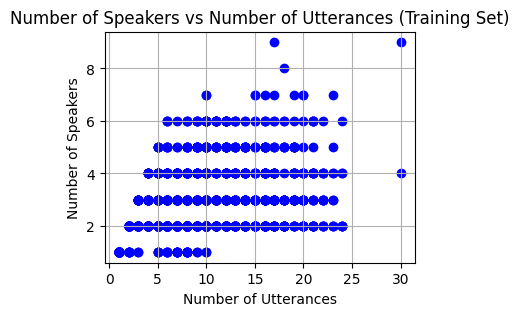

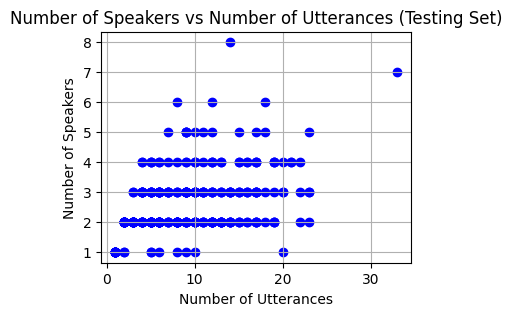

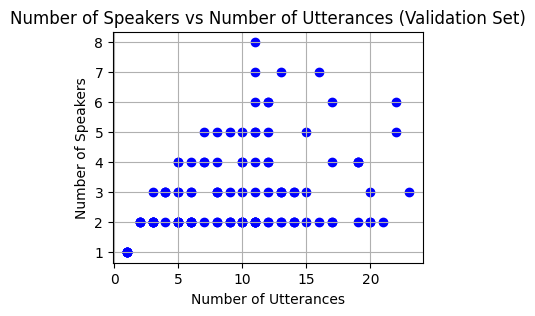

In [6]:
plot_speakers_vs_utterances(MELD_training_graphs, 'Training Set')
plot_speakers_vs_utterances(MELD_testing_graphs, 'Testing Set')
plot_speakers_vs_utterances(MELD_validation_graphs, 'Validation Set')

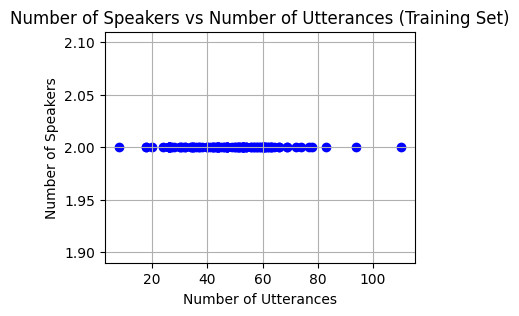

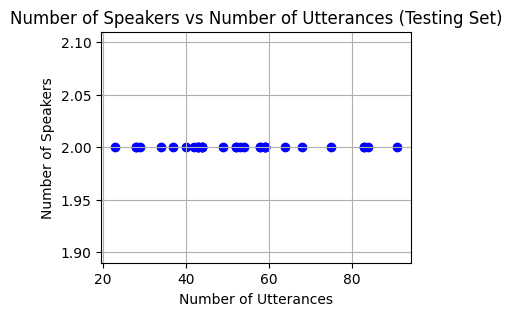

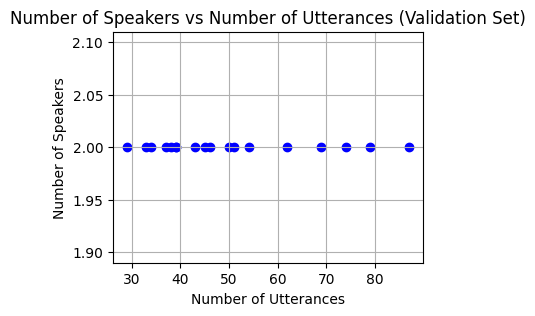

In [7]:
plot_speakers_vs_utterances(IEMOCAP_training_graphs, 'Training Set')
plot_speakers_vs_utterances(IEMOCAP_testing_graphs, 'Testing Set')
plot_speakers_vs_utterances(IEMOCAP_validation_graphs, 'Validation Set')

Below we define the test and train laoder used for model training

In [8]:
from torch_geometric.loader import DataLoader

# Create data loaders as before
MELD_train_loader = DataLoader(MELD_training_graphs, batch_size=32, shuffle=True)
MELD_val_loader = DataLoader(MELD_validation_graphs, batch_size=32, shuffle=False)
MELD_test_loader = DataLoader(MELD_testing_graphs, batch_size=32, shuffle=False)

# Create data loaders
IEMOCAP_train_loader = DataLoader(IEMOCAP_training_graphs, batch_size=5, shuffle=True)
IEMOCAP_val_loader = DataLoader(IEMOCAP_validation_graphs, batch_size=5, shuffle=False)
IEMOCAP_test_loader = DataLoader(IEMOCAP_testing_graphs, batch_size=5, shuffle=False)
    

In [59]:
import torch
import torch.optim as optim
import numpy as np
import copy

device = torch.device("cuda")

# Function for training the model
def train_model(model, train_loader, val_loader, hyperparameters, model_name="best_model.pth", loss_fn = torch.nn.CrossEntropyLoss()):
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])
    num_epochs = hyperparameters['num_epochs']
    patience = hyperparameters['patience']
    print_every = hyperparameters['print_every']
    best_model_state = None

    best_val_loss = np.inf
    patience_counter = 0

    print("============================= STARTING TRAINING ==================================")

    for epoch in range(num_epochs):
        model.train()  
        train_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            # get predictions and output
            output = model(batch) 
            output = output.squeeze(1)
            labels = batch.y

            # Compute loss for batch
            batch_loss = loss_fn(output, labels)

            # Backward pass and optimization
            batch_loss.backward()
            optimizer.step()
            
            train_loss += batch_loss.item()



        # Evaluate on validation set
        val_loss = evaluate_model(model, val_loader, loss_fn=loss_fn)

        # Print updates every n epochs
        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save model if it improves
            # torch.save(model.state_dict(), f'{model_name}.pth')
            best_model_state = copy.deepcopy(model.state_dict())
            print("Model saved successfully.")
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
            
            
    # Load the best model state into the model before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# Function for evaluating the model on validation/test sets
def evaluate_model(model, val_loader, loss_fn):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            output = model(batch)
            output = output.squeeze(1)
            labels = batch.y  # Assuming batch contains ground truth labels for subgraphs
            
            # Compute validation loss
            loss = loss_fn(output, labels)
            val_loss += loss.item()

    return val_loss / len(val_loader)


In [53]:
def compute_class_weights(dataset):
    """
    Compute class weights for imbalanced classes.
    
    :param labels: A tensor or list containing all the true labels from the dataset.
    :return: A tensor with the weights for each class.
    """

    # Define loss function (CrossEntropyLoss for multi-class classification)
    all_labels = []

    # Iterate through the entire dataset to collect all labels
    for data in dataset:
        all_labels.append(data.y)  # Assuming each graph has a 'y' attribute with the labels
    # Concatenate all labels into a single tensor
    all_labels = torch.cat(all_labels, dim=0)
    
    unique_labels, counts = torch.unique(all_labels, return_counts=True)
    
    # Compute the inverse of the frequency of each class
    total_samples = len(all_labels)
    class_weights = total_samples / (len(unique_labels) * counts.float())
    print("Inverse class frequencies: ", class_weights)
    
    return class_weights

In [54]:
hyperparameters = {
    'num_epochs': 50,  
    'learning_rate': 0.0005,  
    'patience': 10, 
    'print_every': 1  
}

In [78]:
import importlib
import ERC_working_models
importlib.reload(ERC_working_models)

<module 'ERC_working_models' from '/home/manuel.nunez/VANESSA/GroupCohesionPrediction/GNNs/ERC/ERC_working_models.py'>

In [79]:
class_weights = compute_class_weights(MELD_training_graphs)
loss_fn_weighted = torch.nn.CrossEntropyLoss(weight=class_weights)

Inverse class frequencies:  tensor([1.5881, 1.5847, 1.5737, 1.0887, 0.3420, 1.5869, 1.5847])


In [84]:
model = ERC_working_models.ITERMEM(output_dim=7)
# model = ERC_working_models.SIMPT(output_dim=6)

model = model.to(device)

/blue/bonniejdorr/manuel.nunez/.conda/envs/VANESSA_env/lib/python3.13/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/blue/bonniejdorr/manuel.nunez/.conda/envs/VANESSA_env/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


In [85]:

# train_model(model, IEMOCAP_test_loader,  IEMOCAP_val_loader, hyperparameters, model_name="ITERMEM_NodeLevel_IEMOCAP_padded_weighted", loss_fn=loss_fn_weighted)
best_model = train_model(model, MELD_test_loader,  MELD_val_loader, hyperparameters, model_name="ITERMEM_NodeLevel_MELD_augmented_training", loss_fn =loss_fn_weighted )

============================= STARTING TRAINING ==================================


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument weight in method wrapper_CUDA_nll_loss_forward)

The function below evaluates a model, plots a confusion matrix, and print the weighted F1 score 

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

def evaluate_and_confusion_matrix(model, classes, test_loader):
    """
    Evaluates the model on the test set, displaying a normalized confusion matrix, per-class accuracy and F1 score, 
    and weighted accuracy and F1 score across all classes.

    :param model: Trained model
    :param classes: List of class names corresponding to labels
    :param test_loader: DataLoader for the test set
    """
    model.eval()  # Set model to evaluation mode
    model = model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)  # Forward pass
            predicted_classes = torch.argmax(output, dim=2).squeeze(1)  # Get predicted classes
            all_preds.append(predicted_classes.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())
    
    # Flatten the lists to single arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Generate confusion matrix and normalize by row
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title("Normalized Confusion Matrix (Proportional Accuracy)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Calculate per-class F1 and accuracy scores
    per_class_f1 = f1_score(all_labels, all_preds, average=None, labels=range(len(classes)))
    per_class_accuracy = cm.diagonal()  # Row-normalized matrix diagonal gives per-class accuracy

    # Print per-class metrics
    print("\nPer-Class Accuracy and F1 Scores:")
    for i, class_name in enumerate(classes):
        print(f"{class_name}: Accuracy: {per_class_accuracy[i]:.2f}, F1 Score: {per_class_f1[i]:.2f}")

    # Calculate and print weighted metrics
    weighted_f1_score = f1_score(all_labels, all_preds, average='weighted')
    weighted_accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nWeighted Accuracy (Overall): {weighted_accuracy:.4f}")
    print(f"Weighted F1 Score (Overall): {weighted_f1_score:.4f}")

    return cm, per_class_f1, weighted_f1_score, per_class_accuracy, weighted_accuracy


The functions below are helper functions for th heatmap function. 

In [70]:
def split_conversations(preds, labels, turns):
        conversations_preds = []
        conversations_labels = []
        conversations_turns = []
        
        current_preds = []
        current_labels = []
        current_turns = []

        for i in range(len(turns)):
            if turns[i] == 0 and i != 0:  # New conversation starts when turns[i] == 0
                conversations_preds.append(current_preds)
                conversations_labels.append(current_labels)
                conversations_turns.append(current_turns)
                
                current_preds = []
                current_labels = []
                current_turns = []
            
            current_preds.append(preds[i])
            current_labels.append(labels[i])
            current_turns.append(turns[i])

        # Append the last conversation
        if current_preds:
            conversations_preds.append(current_preds)
            conversations_labels.append(current_labels)
            conversations_turns.append(current_turns)
        
        return conversations_preds, conversations_labels, conversations_turns

def get_turn_category(num_turns, bins):
    """Determine which category a conversation's number of turns belongs to."""
    if num_turns == bins['single']:
        return 'single'
    elif num_turns == bins['double']:
        return 'double'
    elif bins['short'][0] <= num_turns <= bins['short'][1]:
        return 'short'
    elif bins['mid'][0] <= num_turns <= bins['mid'][1]:
        return 'mid'
    elif num_turns >= bins['long']:
        return 'long'
    return None

Th heatmap function below generate an accuracy heatmap for turn percentiles based on meetinng length. 

In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_by_exchange_length(model, classes, test_loader, bins={"single": 1, "double": 2, "short": (3, 10), "mid": (10, 20), "long": 20}):

    model.eval()  # Set model to evaluation mode
    model = model.to(device)
    all_preds = []
    all_labels = []
    all_turns = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)  # Forward pass
            predicted_classes = torch.argmax(output, dim=2).squeeze(1)  # Shape: (batch_size,)
            all_preds.append(predicted_classes.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())
            all_turns.append(batch.turns.cpu().numpy())

    # Flatten the lists to single arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_turns = np.concatenate(all_turns)
    
    # Step 1: Split by conversations 
    conversations_preds, conversations_labels, conversations_turns = split_conversations(all_preds, all_labels, all_turns)

    # Dictionary to hold correct and total predictions for each category and percentile
    categories = ['single', 'double', 'short', 'mid', 'long']
    correct_by_cat_emotion = {cat: {p: {c: 0 for c in range(len(classes))} for p in range(3)} for cat in categories}
    total_by_cat_emotion = {cat: {p: {c: 0 for c in range(len(classes))} for p in range(3)} for cat in categories}

    #Process conversations and fill the dictionaries
    for preds, labels, turns in zip(conversations_preds, conversations_labels, conversations_turns):
        num_turns = len(turns)
        category = get_turn_category(num_turns, bins)

        if category:
            for i in range(num_turns):
                true_emotion = labels[i]
                predicted_emotion = preds[i]
                # Assign percentile 
                turn_percentile = min(2, i // (num_turns // 3) if num_turns > 2 else i)
                # Update total occurrences for the true emotion at this turn
                total_by_cat_emotion[category][turn_percentile][true_emotion] += 1
                # Update correct predictions if the prediction is correct
                if predicted_emotion == true_emotion:
                    correct_by_cat_emotion[category][turn_percentile][true_emotion] += 1

    
    # Generate heatmaps for each conversation category
    for category in categories:
        # Prepare the numeric accuracy matrix 
        accuracy_matrix = np.zeros((len(classes), 3)) 
        fraction_matrix = np.full((len(classes), 3), '', dtype=object)  # Placeholder for fractions

        for p in range(3):
            for emotion in range(len(classes)):
                if total_by_cat_emotion[category][p][emotion] > 0:
                    accuracy_matrix[emotion][p] = correct_by_cat_emotion[category][p][emotion] / total_by_cat_emotion[category][p][emotion]
                    fraction_matrix[emotion][p] = f'{correct_by_cat_emotion[category][p][emotion]} / {total_by_cat_emotion[category][p][emotion]}'
                else:
                    fraction_matrix[emotion][p] = '0 / 0'


        # Generate the heatmap for shading
        plt.figure(figsize=(8, 6))
        ax = sns.heatmap(accuracy_matrix, annot=False, cmap='Blues', xticklabels=['1st Third', '2nd Third', 'Last Third'], yticklabels=classes)

        # Overlay text (fractions) on top of the heatmap
        for i in range(len(classes)):
            for j in range(3):
                ax.text(j + 0.5, i + 0.5, fraction_matrix[i][j], color='black', ha='center', va='center', fontsize=12)

        plt.title(f"Emotion Prediction Accuracy by Percentile - {category.capitalize()} Exchanges")
        plt.xlabel("Conversation Stage")
        plt.ylabel("Emotions")
        plt.show()



Below we evaluate the model using both evaluation functions. 

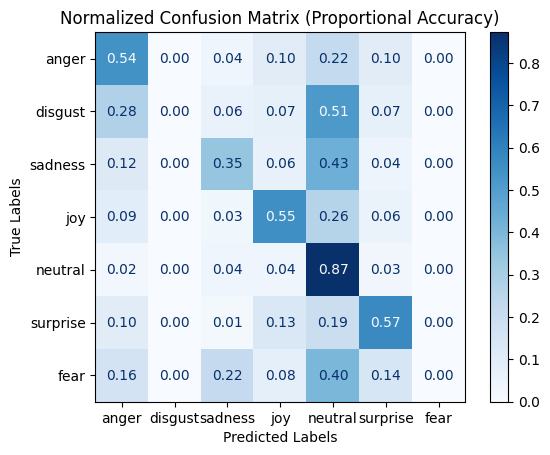


Per-Class Accuracy and F1 Scores:
anger: Accuracy: 0.54, F1 Score: 0.55
disgust: Accuracy: 0.00, F1 Score: 0.00
sadness: Accuracy: 0.35, F1 Score: 0.38
joy: Accuracy: 0.55, F1 Score: 0.58
neutral: Accuracy: 0.87, F1 Score: 0.80
surprise: Accuracy: 0.57, F1 Score: 0.58
fear: Accuracy: 0.00, F1 Score: 0.00

Weighted Accuracy (Overall): 0.6655
Weighted F1 Score (Overall): 0.6414


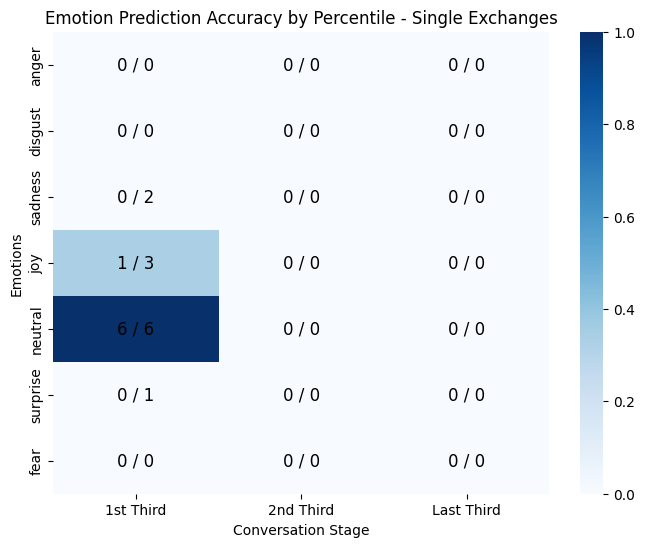

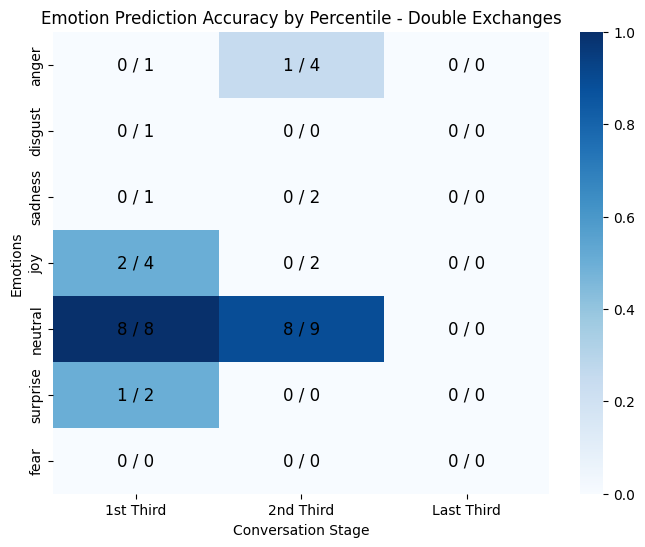

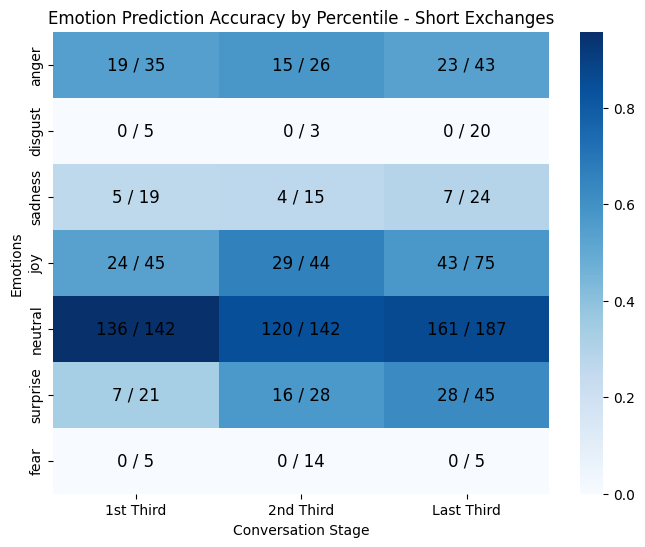

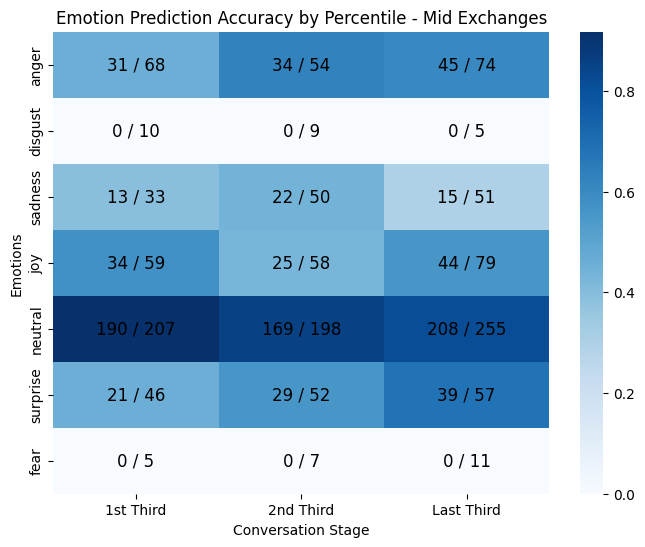

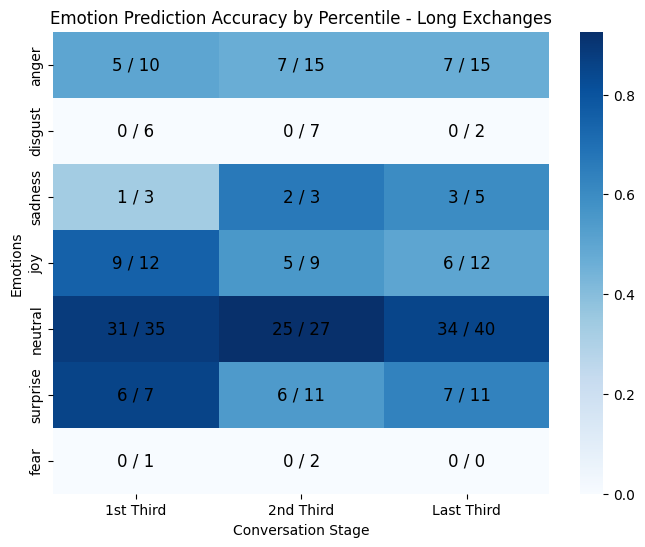

In [82]:
# Load the saved model's state dictionary
# model.load_state_dict(torch.load('ERC_Models/ITERMEM_NodeLevel_MELD_augmented_training.pth'))

MELD_class_names = ['anger', 'disgust', 'sadness', 'joy', 'neutral', 'surprise', 'fear']
IEMOCAP_class_names = {'hap', 'sad', 'neu', 'ang', 'exc', 'fru'}

# evaluate_and_confusion_matrix(model, IEMOCAP_class_names, IEMOCAP_test_loader)
# evaluate_model_by_exchange_length(model, IEMOCAP_class_names, IEMOCAP_test_loader)
evaluate_and_confusion_matrix(best_model, MELD_class_names, MELD_test_loader)
evaluate_model_by_exchange_length(best_model, MELD_class_names, MELD_test_loader)

In [73]:
torch.save(best_model.state_dict(), f'ERC_Models/ITERMEM_MELD_Best_Model_transformer.pth')


AttributeError: '_pickle.Pickler' object attribute 'persistent_id' is read-only